In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="red">10_iris(다중분류_타겟변수_원핫인코딩)</font></b>

In [2]:
import os
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

In [5]:
from sklearn import datasets
dt_iris = datasets.load_iris()

In [36]:
dt_iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [15]:
X_iris = dt_iris.data

In [24]:
y_iris = dt_iris.target
Y_iris = pd.get_dummies(y_iris).to_numpy()

In [50]:
Y_iris[0]

array([1, 0, 0], dtype=uint8)

In [25]:
# 훈련셋과 테스트셋 분리(층화추출) = 8:2
X_train, X_test, Y_train, Y_test =train_test_split(X_iris, Y_iris,
                                                  train_size=0.8,
                                                  stratify=Y_iris,
                                                  random_state=3)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

In [26]:
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 50)                6450      
                                                                 
 dense_9 (Dense)             (None, 30)                1530      
                                                                 
 dense_10 (Dense)            (None, 20)                620       
                                                                 
 dense_11 (Dense)            (None, 3)                 63        
                                                                 
Total params: 17,303
Trainable params: 17,303
Non-trai

In [27]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model10/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.1633, acc:0.3333, val_loss:1.1005, val_acc:0.3333
5번째 loss:0.9859, acc:0.3333, val_loss:0.9656, val_acc:0.6667
10번째 loss:0.9060, acc:0.6667, val_loss:0.8780, val_acc:0.6667
15번째 loss:0.8137, acc:0.6667, val_loss:0.7815, val_acc:0.6667
20번째 loss:0.7034, acc:0.7083, val_loss:0.6632, val_acc:0.8333
25번째 loss:0.5748, acc:0.8438, val_loss:0.5278, val_acc:0.9583
30번째 loss:0.4395, acc:0.9479, val_loss:0.3887, val_acc:0.9583
35번째 loss:0.3238, acc:0.9583, val_loss:0.2733, val_acc:1.0000
40번째 loss:0.2403, acc:0.9688, val_loss:0.1898, val_acc:1.0000
45번째 loss:0.1792, acc:0.9688, val_loss:0.1317, val_acc:1.0000
50번째 loss:0.1345, acc:0.9792, val_loss:0.0923, val_acc:1.0000
55번째 loss:0.1042, acc:0.9792, val_loss:0.0686, val_acc:1.0000
60번째 loss:0.0848, acc:0.9792, val_loss:0.0533, val_acc:1.0000
65번째 loss:0.0717, acc:0.9792, val_loss:0.0438, val_acc:1.0000
70번째 loss:0.0622, acc:0.9792, val_loss:0.0367, val_acc:1.0000
75번째 loss:0.0559, acc:0.9792, val_loss:0.0323, val_acc:1.0000
80번째 loss:

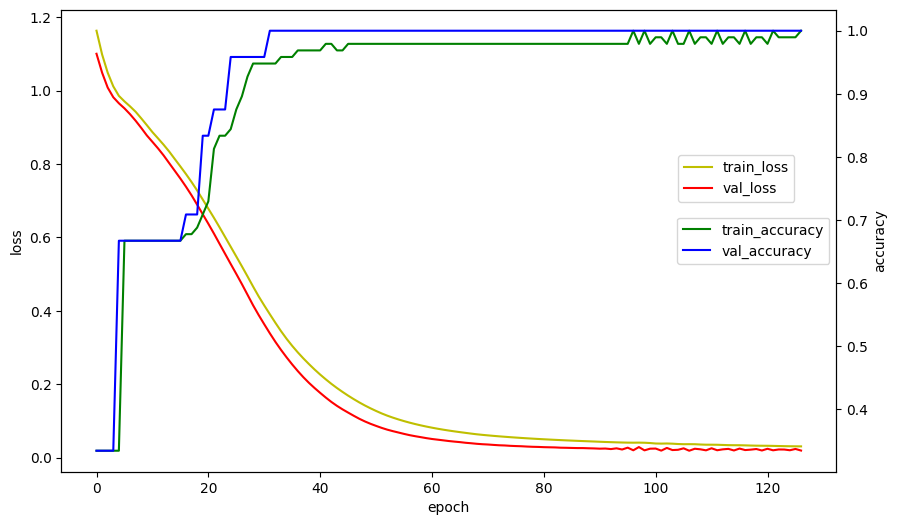

In [28]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [29]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.2184, accuracy:0.9667


In [31]:
model1 = load_model('model10/iris-032-loss0.3389-acc1.0000.h5')
loss_and_acc1 =model1.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:0.3745, accuracy:0.9667


In [30]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test), axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

1/1 [==============================] - 0s 74ms/step


predict,0,1,2
real,,,
0,10,0,0
1,0,9,1
2,0,0,10
